In [1]:
import torch
import random
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained(
    'processor/microsoft/trocr-base-handwritten')

processor

/root/miniconda3/envs/pt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TrOCRProcessor:
- image_processor: ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "processor_class": "TrOCRProcessor",
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width": 384
  }
}

- tokenizer: RobertaTokenizerFast(name_or_path='processor/microsoft/trocr-base-handwritten', vocab_size=50265, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_w

In [2]:
from datasets import load_from_disk, Dataset

def f():
    dataset = load_from_disk('dataset/lansinuote/ocr_id_card_small')['train']
    for data in dataset:
        for box in data['ocr']:
            image = data['image'].crop(box['box'])
            yield {'image': image, 'text': box['word']}


dataset = Dataset.from_generator(f)

dataset, dataset[0]

(Dataset({
     features: ['image', 'text'],
     num_rows: 68000
 }),
 {'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=34x26>,
  'text': '竺航欣'})

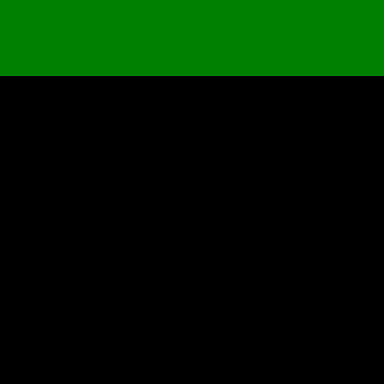

In [3]:
import PIL.Image


def pad(image):
    w, h = image.size

    ratio = 384 / max(w, h)

    w = int(ratio * w)
    h = int(ratio * h)

    image = image.resize([w, h])

    pad = PIL.Image.new('RGB', [384, 384], 'black')
    pad.paste(image, [0, 0])

    return pad


pad(PIL.Image.new('RGB', [100, 20], 'green'))

In [4]:
def f(data):
    image = [i['image'] for i in data]
    text = [i['text'] for i in data]

    image = [pad(i) for i in image]
    pixel_values = processor(image,
                             return_tensors='pt').pixel_values.to('cuda')

    input_ids = processor.tokenizer(text,
                                    truncation=True,
                                    padding='max_length',
                                    max_length=128,
                                    return_tensors='pt').input_ids.to('cuda')

    return pixel_values, input_ids


loader = torch.utils.data.DataLoader(dataset,
                                     batch_size=8,
                                     shuffle=True,
                                     drop_last=True,
                                     collate_fn=f)

len(loader), next(iter(loader))

(8500,
 (tensor([[[[ 0.7333,  0.7333,  0.7333,  ..., -1.0000, -1.0000, -1.0000],
            [ 0.7333,  0.7333,  0.7333,  ..., -1.0000, -1.0000, -1.0000],
            [ 0.7333,  0.7333,  0.7333,  ..., -1.0000, -1.0000, -1.0000],
            ...,
            [ 0.7569,  0.7569,  0.7569,  ..., -1.0000, -1.0000, -1.0000],
            [ 0.7569,  0.7569,  0.7569,  ..., -1.0000, -1.0000, -1.0000],
            [ 0.7569,  0.7569,  0.7569,  ..., -1.0000, -1.0000, -1.0000]],
  
           [[ 0.7176,  0.7176,  0.7176,  ..., -1.0000, -1.0000, -1.0000],
            [ 0.7176,  0.7176,  0.7176,  ..., -1.0000, -1.0000, -1.0000],
            [ 0.7176,  0.7176,  0.7176,  ..., -1.0000, -1.0000, -1.0000],
            ...,
            [ 0.7569,  0.7569,  0.7569,  ..., -1.0000, -1.0000, -1.0000],
            [ 0.7569,  0.7569,  0.7569,  ..., -1.0000, -1.0000, -1.0000],
            [ 0.7569,  0.7569,  0.7569,  ..., -1.0000, -1.0000, -1.0000]],
  
           [[ 0.8353,  0.8353,  0.8353,  ..., -1.0000, -1.0000,

In [5]:
class Model(torch.nn.Module):

    def __init__(self):
        super().__init__()
        from transformers import VisionEncoderDecoderConfig, ViTModel, TrOCRForCausalLM

        config = VisionEncoderDecoderConfig.from_pretrained(
            'model/microsoft/trocr-base-stage1')

        self.encoder = ViTModel(config.encoder)
        self.decoder = TrOCRForCausalLM(config.decoder)

        from transformers import VisionEncoderDecoderModel
        parameters = VisionEncoderDecoderModel.from_pretrained(
            'model/microsoft/trocr-base-stage1')
        self.encoder.load_state_dict(parameters.encoder.state_dict())
        self.decoder.load_state_dict(parameters.decoder.state_dict())
        del parameters

        self.train()
        self.to('cuda')

    def forward(self, pixel_values, input_ids):
        last_hidden_state = self.encoder(pixel_values).last_hidden_state

        input_ids_shifted = torch.zeros_like(input_ids)
        input_ids_shifted[:, 1:] = input_ids[:, :-1].clone()
        input_ids_shifted[:, 0] = processor.tokenizer.cls_token_id

        return self.decoder(input_ids=input_ids_shifted,
                            encoder_hidden_states=last_hidden_state).logits


model = Model()

with torch.no_grad():
    print(model(*next(iter(loader))))

tensor([[[-14.1799, -13.0640,  17.2174,  ..., -13.2261, -12.8938, -12.4115],
         [-14.3717, -12.1054,  16.0542,  ..., -12.7422, -12.3026, -11.7065],
         [-14.9569, -14.3023,  20.8267,  ..., -12.4403, -13.7137, -13.9828],
         ...,
         [-12.4660, -11.0656,  13.1166,  ..., -10.5550, -10.2515,  -9.0241],
         [-12.2930, -10.8654,  12.5837,  ...,  -9.5283,  -9.6744,  -9.0811],
         [-11.8245, -11.0631,  13.3300,  ..., -10.3409, -10.3689,  -9.8629]],

        [[-13.0578, -12.1496,  10.7289,  ..., -10.6659, -11.7826, -10.5593],
         [-12.0332, -11.2219,  11.0270,  ..., -10.3884, -10.2945,  -9.3870],
         [ -8.1516,  -7.7701,   7.6458,  ...,  -7.0550,  -6.5954,  -5.0459],
         ...,
         [ -8.9883,  -9.7864,  11.1451,  ...,  -9.1666,  -8.3429,  -8.3415],
         [ -8.8382,  -9.3286,  11.3010,  ...,  -8.7331,  -8.3127,  -7.7316],
         [ -8.5409,  -9.2079,  11.3378,  ...,  -8.7921,  -7.8968,  -7.6786]],

        [[-11.9076, -11.4643,  10.3825,  ...

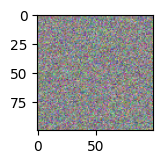

In [6]:
import numpy as np
import PIL.Image
from matplotlib import pyplot as plt


def show(image):
    image = image - image.min()
    image = image / image.max() * 255
    image = image.permute(1, 2, 0)
    image = np.uint8(image.to('cpu').numpy())
    image = PIL.Image.fromarray(image, 'RGB')

    plt.figure(figsize=(1.5, 1.5))
    plt.imshow(image)
    plt.show()


show(torch.randn(3, 100, 100))

In [7]:
def decode(input_ids):
    input_ids = input_ids.to('cpu').tolist()

    if processor.tokenizer.sep_token_id in input_ids:
        idx = input_ids.index(processor.tokenizer.sep_token_id) + 1
        input_ids = input_ids[:idx]

    return processor.tokenizer.decode(input_ids)


decode(torch.LongTensor([0, 19751, 12590, 2534, 13, 2, 1, 1]))

'<s>Insurance Institute for</s>'

0 0 10.310846328735352


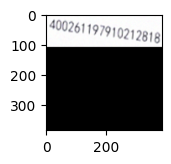

<s>400261197910212818</s>
</s>
0 4000 0.9099838137626648


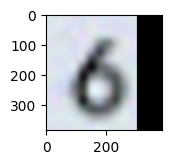

<s>6</s>
<s><s></s>
0 8000 0.43903306126594543


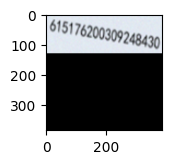

<s>615176200309248430</s>
61561517620030248430</s>
1 0 0.5980579853057861


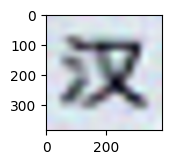

<s>汉</s>
<s>汉</s>
1 4000 0.1643870323896408


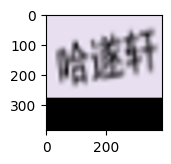

<s>哈遂轩</s>
<s>哈遂轩</s>
1 8000 0.23409408330917358


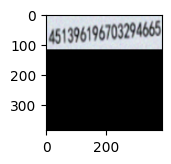

<s>451396196703294665</s>
<s>451396196702965</s>
2 0 0.002003859495744109


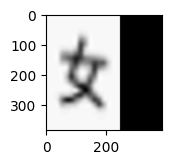

<s>女</s>
<s>女</s>
2 4000 0.05571634694933891


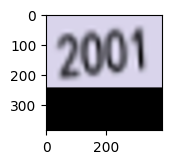

<s>2001</s>
<s>2001</s>
2 8000 0.08789309114217758


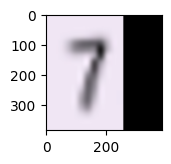

<s>7</s>
<s>7</s>
3 0 0.14115796983242035


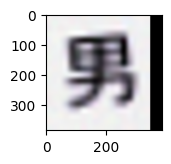

<s>男</s>
<s>男</s>
3 4000 0.18202462792396545


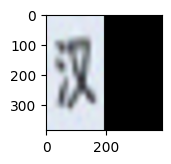

<s>汉</s>
<s>汉</s>
3 8000 0.009743084199726582


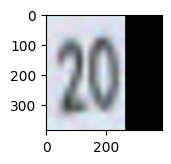

<s>20</s>
<s>20</s>
4 0 0.19539643824100494


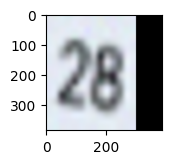

<s>28</s>
<s>28</s>
4 4000 0.02773418463766575


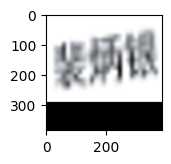

<s>裴炳银</s>
<s>裴炳银</s>
4 8000 0.007153387647122145


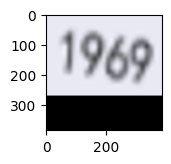

<s>1969</s>
<s>1969</s>
5 0 0.008603602647781372


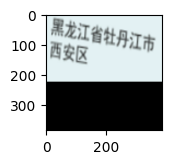

<s>黑龙江省牡丹江市西安区</s>
<s>黑龙江省牡丹江市西安区</s>
5 4000 0.047734394669532776


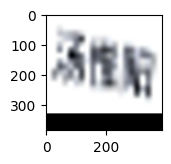

<s>汤惟阳</s>
<s>汤惟阬</s>
5 8000 0.0013977399794384837


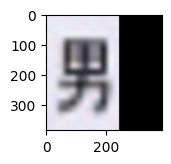

<s>男</s>
<s>男</s>
6 0 5.162729576113634e-05


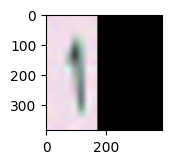

<s>1</s>
<s>1</s>
6 4000 0.017933450639247894


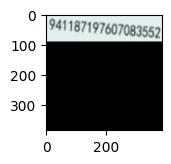

<s>941187197607083552</s>
<s>94118719760703552</s>
6 8000 0.0007695865351706743


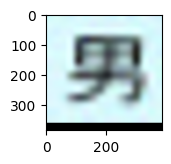

<s>男</s>
<s>男</s>
7 0 0.004089913330972195


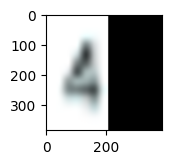

<s>4</s>
<s>4</s>
7 4000 0.005235392600297928


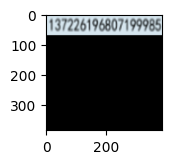

<s>137226196807199985</s>
<s>137226196807199985</s>
7 8000 0.006602725479751825


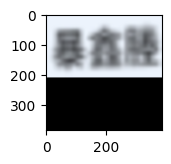

<s>暴鑫塍</s>
<s>暴鑫塍</s>
8 0 0.010091652162373066


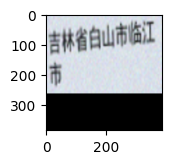

<s>吉林省白山市临江市</s>
<s>吉林省白山市临江市</s>
8 4000 0.02746739611029625


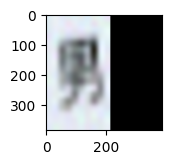

<s>男</s>
<s>男</s>
8 8000 0.08212078362703323


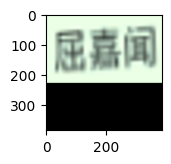

<s>屈嘉闻</s>
<s>居嘉闻</s>
9 0 0.003792027710005641


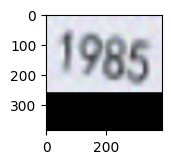

<s>1985</s>
<s>1985</s>
9 4000 0.00017483554256614298


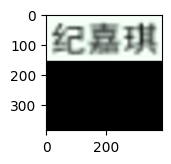

<s>纪嘉琪</s>
<s>纪嘉琪</s>
9 8000 0.000692034256644547


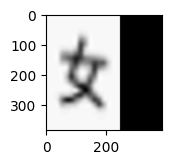

<s>女</s>
<s>女</s>
10 0 8.209969382733107e-05


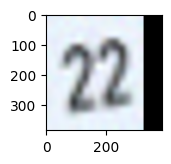

<s>22</s>
<s>22</s>
10 4000 0.015325118787586689


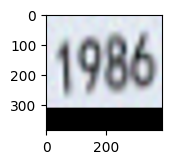

<s>1986</s>
<s>1986</s>
10 8000 0.00024113201652653515


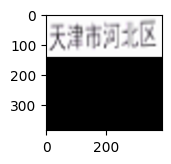

<s>天津市河北区</s>
<s>天津市河北区</s>
11 0 0.011580057442188263


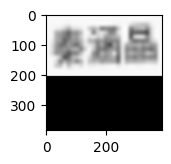

<s>秦涵晶</s>
<s>秦涵晶</s>
11 4000 0.0001735853002173826


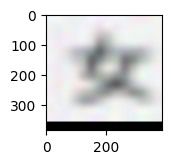

<s>女</s>
<s>女</s>
11 8000 0.0028663191478699446


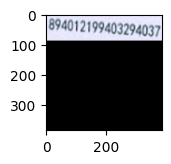

<s>894012199403294037</s>
<s>894012199403294037</s>
12 0 0.0001909195416374132


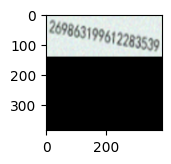

<s>269863199612283539</s>
<s>269863199612283539</s>
12 4000 0.009443390183150768


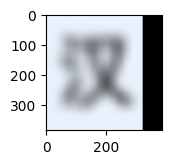

<s>汉</s>
<s>汉</s>
12 8000 0.01198561117053032


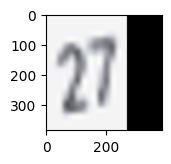

<s>27</s>
<s>27</s>
13 0 8.758516196394339e-05


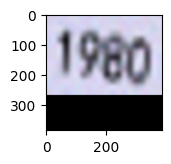

<s>1980</s>
<s>1980</s>
13 4000 0.05855000391602516


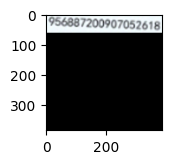

<s>956887200907052618</s>
<s>95688700907052618</s>
13 8000 7.168539923441131e-06


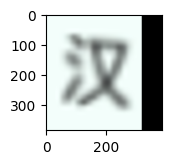

<s>汉</s>
<s>汉</s>
14 0 9.276337368646637e-05


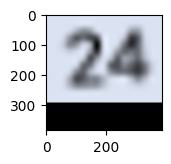

<s>24</s>
<s>24</s>
14 4000 0.013100631535053253


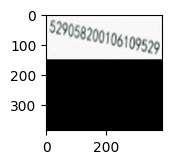

<s>529058200106109529</s>
<s>529058200106109529</s>
14 8000 6.660918734269217e-05


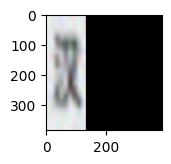

<s>汉</s>
<s>汉</s>


In [8]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss(
    ignore_index=processor.tokenizer.pad_token_id)

for epoch in range(15):
    for i, (pixel_values, input_ids) in enumerate(loader):
        logits = model(pixel_values, input_ids)

        loss = criterion(logits.flatten(0, 1), input_ids.flatten())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        if i % 4000 == 0:
            print(epoch, i, loss.item())
            testi = random.randint(0, 7)
            show(pixel_values[testi])
            print(decode(input_ids[testi]))
            print(decode(logits[testi].argmax(1)))
            
torch.save(model.to('cpu'), 'model/文字识别.model')